Commencing SLP Training...
Ending SLP Training.
Commencing SLP Noiseless Testing...
Ending SLP Noiseless Testing.
Commencing SLP Noisy Testing...


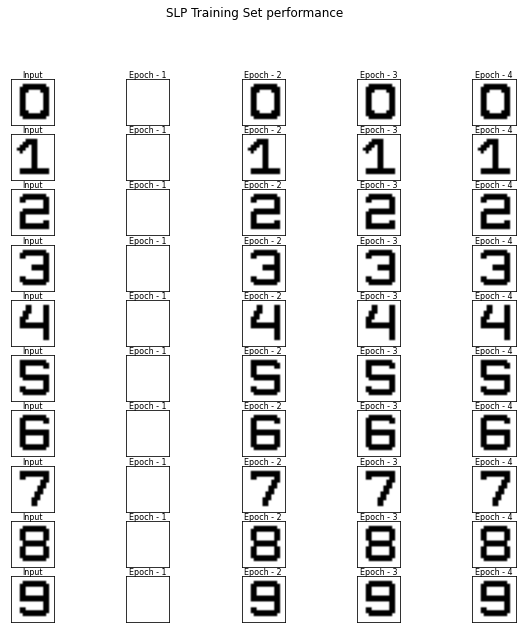

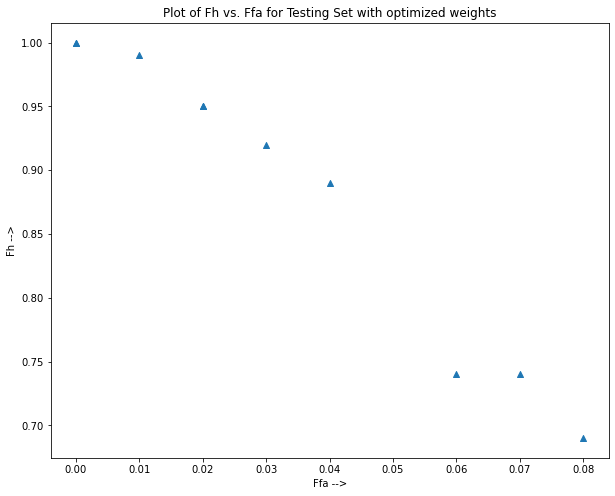

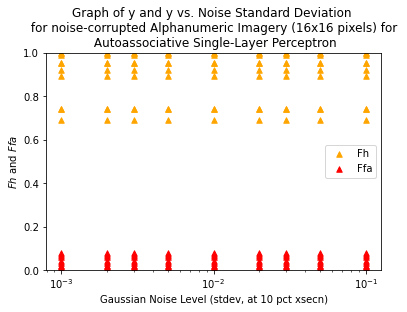

Ending SLP Noisy Testing.


In [40]:
'''
CAP6615 - Spring 2022
Assignment #1 - Single- and Multi-Layer Shallow Neural Networks
'''

import numpy as np
import os
import sys
from PIL import Image
import pandas
import matplotlib.pyplot as plt

class performanceMetrics(object):
    def __init__(self, fh, ffa):
        self.fh = fh
        self.ffa = ffa

class SLP_Update_Metrics(object):
    def __init__(self, predictionsArray, weightMatrix):
        self.predictions = predictionsArray
        self.weights = weightMatrix
    

class Perceptron():
    def __init__(self):
        '''
        Initialize perceptron model.
        '''

    def activation_fn(self,x):
        #     Sigmoid Activation func: f(x) = 1/(1+e^(-x))
        return 1/(1+np.exp(-x))
        
    def _initialize_weights(self,rows,columns):
        '''
        Initialize the weights, initalize using random numbers.
        '''
        return np.random.rand(rows,columns)

    def predict(self,inputVector, weightMatrix):
        
        predictionVector = []
        for i in range(len(weightMatrix)):
            row_sum = sum(
                (inputVector[j] * weightMatrix[j][i])
                for j in range(len(weightMatrix[0]) - 1)
            )

            predictionVector.append(self.activation_fn(row_sum))
        # print('Prediction')
        # print(predictionVector)   
        return predictionVector

    def add_noise(self, outputVector,noise_percent,stdev):
        mean = 0
        noise = np.random.normal(mean,stdev,outputVector.shape) * noise_percent 
        corruptedVector = outputVector + noise

        return corruptedVector

    def calculate_performance_metrics(self, predictionVector, inputVector, outputVector):
        
        totalBlackPixelCount = sum(x == 0 for x in inputVector)
        totalWhitePixelCount = sum(x == 1 for x in inputVector)
        wrongBlackPixelCount = 0
        rightBlackPixelCount = 0
        for i in range(len(outputVector)):
            if outputVector[i] < 0.0001:
                if  abs(predictionVector[i] - inputVector[i]) < 0.0001:
                    rightBlackPixelCount += 1
                else:
                    wrongBlackPixelCount += 1
        fh = rightBlackPixelCount/totalBlackPixelCount
        ffa = wrongBlackPixelCount/totalWhitePixelCount
        return performanceMetrics(fh,ffa)    

    def updateBias(self, predictionVector, outputVector, inputVector, biasVector):
        
        learningRate = 0.8
        for i in range(len(outputVector)):
            error = outputVector[i] - predictionVector[i]
            biasVector[i][0] += (learningRate*inputVector[i]*error) 
        return biasVector


    def fit(self,predictionVector,outputVector,inputVector,weightMatrix):
        
        learningRate = 0.8
        for i in range(len(weightMatrix)):
            error = outputVector[i] - predictionVector[i]
            for j in range(len(weightMatrix[0])):
                weightMatrix[j][i] += (learningRate*inputVector[j]*error) 
        return weightMatrix
    
    def getInputImageVectors(self,count):
        ImageVectors = []
        
        for i in range(count):
            path = os.path.join(os.path.dirname(os.path.abspath(sys.argv[1])),'numbers','pixil-frame-'+ str(i) +'.png')
            im = Image.open(path, 'r')
            gray = im.convert('L')
            bw = gray.point(lambda x: 0 if x<135 else 1, '1')
            ImageVectors.append(np.array(list(bw.getdata())))
        return ImageVectors

    def getPredictedImage(self, predictionVector):
        tempArray = [0]*len(predictionVector)
        for i in range(len(predictionVector)):
            if predictionVector[i] < 0.0001:
                tempArray[i] = (0,0,0)
            elif predictionVector[i] == 1.0:
                tempArray[i] =  (255,255,255)
        finalImage = [tempArray[i:i+15] for i in range(0,len(tempArray),16)]

        imageArray = np.array(finalImage, dtype=np.uint8)
        return Image.fromarray(imageArray)

    def displayTrainingPredictions(self, predictionDataArray):
        f,axisArray = plt.subplots(len(predictionDataArray),len(predictionDataArray[0]),figsize=(10,10))
        plt.suptitle('SLP Training Set performance')
        for i in range(len(predictionDataArray)):
            for j in range(len(predictionDataArray[0])):
                axisArray[i,j].axes.xaxis.set_visible(False)
                axisArray[i,j].axes.yaxis.set_visible(False)
                if j == 0:
                    axisArray[i,j].set_title('Input', fontsize=8,x =0.5,y = 0.9)
                else:
                    axisArray[i,j].set_title('Epoch - '+ str(j), fontsize=8, x =0.5,y = 0.9)
                axisArray[i,j].imshow(self.getPredictedImage(predictionDataArray[i][j]))
                
    def SLP_Training(self,epochs,inputImageVector):
        epochPredictions = []
        epochPredictions.append(inputImageVector)
        weightMatrix = self._initialize_weights(len(inputImageVector),len(inputImageVector))
        # biasVector = np.random.rand(len(pix_val_1),1)
        for _ in range(epochs):
            prediction = self.predict(inputImageVector,weightMatrix)
            epochPredictions.append(prediction)
            weightMatrix = self.fit(prediction,inputImageVector,inputImageVector,weightMatrix)
            # biasVector = self.updateBias(prediction,pix_val_1,pix_val_1,biasVector)

        return SLP_Update_Metrics(epochPredictions,weightMatrix)

    def SLP_Testing(self,testRounds,weightMatrix,inputImageVectors):
        tableObject = {}
        plotObject = {}
        tableObject['_fh'] = []
        tableObject['_ffa'] = []
        plotObject['_fh_plot'] = []
        plotObject['_ffa_plot'] = []
    
        for k in range(testRounds):
            testPrediction = self.predict(inputImageVectors[k],weightMatrix)
            testMetric = self.calculate_performance_metrics(testPrediction,inputImageVectors[k],inputImageVectors[k])
            tableObject['_fh'].append(round(testMetric.fh,2))
            plotObject['_fh_plot'].append(round(testMetric.fh,2))
            tableObject['_ffa'].append(round(testMetric.ffa,2))
            plotObject['_ffa_plot'].append(round(testMetric.ffa,2))

        f,axis = plt.subplots(figsize=(10,8))
        axis.scatter(x=plotObject['_ffa_plot'],y=plotObject['_fh_plot'],marker="^")
        axis.set_xlabel('Ffa -->')
        axis.set_ylabel('Fh -->')
        axis.set_title('Plot of Fh vs. Ffa for Testing Set with optimized weights')

    def SLP_Noisy_Testing(self, stdev, testRounds, weightMatrix, inputImageVectors):
        tableObject = {}
        plotObject = {}
        
        plotObject['fh'] = []
        plotObject['ffa'] = []

        for i in range(len(stdev)):
            tableObject['std_'+ str(stdev[i]) + '_fh'] = []
            tableObject['std_'+ str(stdev[i]) + '_ffa'] = []
        
        for j in range(len(stdev)):   
            for k in range(testRounds) :
                corruptedVector = self.add_noise(inputImageVectors[k],0.1,stdev[j]) 
                testPrediction = self.predict(corruptedVector,weightMatrix)
                testMetric = self.calculate_performance_metrics(testPrediction,inputImageVectors[k],inputImageVectors[k])
                tableObject['std_'+ str(stdev[j]) + '_fh'].append(round(testMetric.fh,2))
                plotObject['fh'].append(round(testMetric.fh,2))
                tableObject['std_'+ str(stdev[j]) + '_ffa'].append(round(testMetric.ffa,2))
                plotObject['ffa'].append(round(testMetric.ffa,2))
        
        pandas.DataFrame(tableObject).to_csv('Test_Results.csv')

        x = np.array([0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 
                  0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002,
                  0.003, 0.003, 0.003, 0.003, 0.003, 0.003, 0.003, 0.003, 0.003, 0.003,
                  0.005, 0.005, 0.005, 0.005, 0.005, 0.005, 0.005, 0.005, 0.005, 0.005,
                  0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
                  0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02,
                  0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03,
                  0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05,
                  0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])
    
        fig, ax = plt.subplots()
        
        ax.scatter(x, plotObject['fh'], label="Fh", marker= "^", color="orange", s=30)
        ax.scatter(x, plotObject['ffa'], label="Ffa", marker= "^", color="red", s=30)
        
        plt.ylim(0, 1)
        ax.set_xscale('log')
        # ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        
        plt.xlabel('Gaussian Noise Level (stdev, at 10 pct xsecn)')
        plt.ylabel("$\it{Fh}$ and $\it{Ffa}$")
        plt.title('Graph of y and y vs. Noise Standard Deviation \n for noise-corrupted Alphanumeric Imagery (16x16 pixels) for \n Autoassociative Single-Layer Perceptron')
        plt.legend()
        plt.show()

     
            
        
       
    


    def SLP(self):
            
        print('Commencing SLP Training...')

        trainingMetrics = []

        InputImageVectors = self.getInputImageVectors(10)

        for i in range(10):
            trainingMetrics.append(self.SLP_Training(4,InputImageVectors[i]).predictions)

        self.displayTrainingPredictions(trainingMetrics)

        print('Ending SLP Training.')

        print('Commencing SLP Noiseless Testing...')

        optimizedWeights = self.SLP_Training(4,InputImageVectors[9]).weights
        
        self.SLP_Testing(10,optimizedWeights,InputImageVectors)

        print('Ending SLP Noiseless Testing.')

        print('Commencing SLP Noisy Testing...')
        
        stdev = [0.001, 0.002, 0.003, 0.005, 0.01, 0.02, 0.03, 0.05,0.1]

        self.SLP_Noisy_Testing(stdev,10,optimizedWeights,InputImageVectors)

        print('Ending SLP Noisy Testing.')
        
        
if __name__ == "__main__":
    perceptron = Perceptron()
    perceptron.SLP()

In [30]:
# def metrics(input, output):
#     blkPixels = 0.0 # No. of black pixels
#     wtPixels = 0.0 # No. of white pixels
#     correctPixels = 0.0 # No. of correct (black) pixels
#     wrongPixels = 0.0 # No. of wrong (black) pixels
    
#     for i in range(len(input)):
#         if input[i] == 1: # black = '1'
#             blkPixels += 1
#         if input[i] == 0: # white = '0'
#             wtPixels += 1
#         if input[i] == 1 and output[i] == 1: # correct black match
#             correctPixels += 1
#         if input[i] == 1 and output[i] == 0: # incorrect black/white mismatch
#             wrongPixels += 1
    
#     Fh = float(correctPixels / blkPixels)
#     Ffa = float(wrongPixels / wtPixels)
    
#     return Fh, Ffa

In [31]:
# # Training set
#     # Dummy values
#     a = [0, 1, 1, 0, 1]
#     b = [0, 0, 1, 1, 1]
#     Fh, Ffa = metrics(a, b)
#     plt.scatter(Ffa, Fh, label= "Digits 0-9", marker= "^", color="green", s=30)
#     plt.xlabel('Ffa')
#     plt.ylabel('Fh')
#     plt.title('Fh vs. Ffa for training set')
#     plt.show()
    
    
#     # Test set (graph)
#     # Dummy values
#     Fhs = np.random.uniform(low=0.2, high=0.8, size=(90,))
#     Ffas = np.random.uniform(low=0.2, high=0.8, size=(90,))
    
#     x = np.array([0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 
#                   0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002,
#                   0.003, 0.003, 0.003, 0.003, 0.003, 0.003, 0.003, 0.003, 0.003, 0.003,
#                   0.005, 0.005, 0.005, 0.005, 0.005, 0.005, 0.005, 0.005, 0.005, 0.005,
#                   0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
#                   0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02,
#                   0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03,
#                   0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05,
#                   0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])
    
#     fig, ax = plt.subplots()
    
#     ax.scatter(x, Fhs, label="Fh", marker= "^", color="orange", s=30)
#     ax.scatter(x, Ffas, label="Ffa", marker= "^", color="red", s=30)
    
#     plt.ylim(0, 1)
#     ax.set_xscale('log')
#     ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    
#     plt.xlabel('Gaussian Noise Level (stdev, at 10 pct xsecn)')
#     plt.ylabel("$\it{Fh}$ and $\it{Ffa}$")
#     plt.title('Graph of y and y vs. Noise Standard Deviation \n for noise-corrupted Alphanumeric Imagery (16x16 pixels) for \n Autoassociative Single-Layer Perceptron')
#     plt.legend()
#     plt.show()